In [ ]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [ ]:
class CSTR_Env(gym.Env):
    """
    Two-CSTRs in series WITH VARIABLE PIPE DELAY.
    The delay is calculated by integrating the flow rate Q(t) backwards
    until the pipe volume V_pipe is reached.
    """
    metadata = {"render_modes": ["human"]}

    def __init__(self, X):
        super().__init__()
        # X = [V1, V2, C_in, half_life, HRT_min, HRT_max, C_limit,
        #      penalty, alpha, beta, dt, obs_noise, V_pipe]

        self.V1 = float(X[0])
        self.V2 = float(X[1])
        self.Vt = self.V1 + self.V2
        self.C_in = float(X[2])
        self.half_life = float(X[3])
        self.HRT_min = float(X[4])
        self.HRT_max = float(X[5])
        self.C_limit = float(X[6])
        self.C_exceed_penalty = float(X[7])
        self.alpha = float(X[8])
        self.beta = float(X[9])
        self.dt = float(X[10])
        self.obs_noise = float(X[11])
        self.V_pipe = float(X[12])

        self.k = np.log(2.0) / max(self.half_life, 1e-12)
        self.Q_min = self.Vt / self.HRT_max
        self.Q_max = self.Vt / self.HRT_min

        # History storage for continuous lookup: [[time, C1, Q]]
        self.history = []

        self.action_space = spaces.Box(low=0.0, high=1.0, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(
            low=np.array([0.0, 0.0], dtype=np.float32),
            high=np.array([self.C_in * 2.5, self.C_in * 2.5], dtype=np.float32)
        )

        self.C1 = self.C2 = None
        self.current_step = 0

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.C1 = float(self.C_in)
        self.C2 = float(self.C_in)

        # Pre-fill history to handle t < 0.
        # We fill back to the maximum possible delay time.
        max_tau = self.V_pipe / self.Q_min
        Q_init = (self.Q_min + self.Q_max) / 2

        self.history = []
        for t in np.arange(-max_tau - self.dt, 0.01, self.dt):
            self.history.append([float(t), self.C1, Q_init])

        return self._get_obs(), {}

    def _get_obs(self):
        obs = np.array([self.C1, self.C2], dtype=np.float32)
        if self.obs_noise > 0:
            obs += self.np_random.normal(loc=0.0, scale=self.obs_noise, size=(2,))
        return np.clip(obs, self.observation_space.low, self.observation_space.high)

    def interpolate_history(self, t_query, data_index):
        """Linearly interpolates past data (C1 or Q) at any continuous time t_query."""
        h_times = [h[0] for h in self.history]
        h_values = [h[data_index] for h in self.history]
        return np.interp(t_query, h_times, h_values)

    def get_delayed_C1(self, current_time):
        """
        Uses solve_ivp to integrate flow backwards to find the delay time.
        Returns the C1 concentration that left R1 exactly when the pipe was 'filled'.
        """
        def volume_ode(t, V):
            return self.interpolate_history(t, 2) # index 2 is Q

        def pipe_full_event(t, V):
            return V[0] - self.V_pipe
        pipe_full_event.terminal = True

        sol = solve_ivp(
            fun=volume_ode,
            t_span=(current_time, self.history[0][0]),
            y0=[0.0],
            events=pipe_full_event,
            method='RK45'
        )

        t_past = sol.t[-1]
        return self.interpolate_history(t_past, 1) # index 1 is C1

    def _ode_rhs(self, t, y, Q, C_in_step, C1_delayed):
        C1, C2 = y
        dC1 = -self.k * C1 - (Q / self.V1) * (C1 - C_in_step)
        dC2 = -self.k * C2 - (Q / self.V2) * (C2 - C1_delayed)
        return [dC1, dC2]

    def step(self, action):
        a = float(np.clip(action, 0, 1).item())
        Q = self.Q_min + a * (self.Q_max - self.Q_min)
        current_time = self.current_step * self.dt

        C1_delayed = self.get_delayed_C1(current_time)

        # Step
        C_in_step = self.C_in * (1 + self.np_random.uniform(-0.1, 0.1))
        sol = solve_ivp(
            fun=lambda t, y: self._ode_rhs(t, y, Q, C_in_step, C1_delayed),
            t_span=(0.0, self.dt),
            y0=[self.C1, self.C2],
            method="RK45"
        )

        self.C1 = max(float(sol.y[0, -1]), 0.0)
        self.C2 = max(float(sol.y[1, -1]), 0.0)
        self.current_step += 1

        self.history.append([current_time + self.dt, self.C1, Q])

        max_tau = self.V_pipe / self.Q_min
        while self.history[-1][0] - self.history[0][0] > max_tau + self.dt * 2:
            self.history.pop(0)

        # Reward Logic
        reward_conc = -self.alpha * self.C2
        reward_throughput = -self.beta * ((self.Vt / Q) - self.HRT_min)
        exceedance = max(0.0, self.C2 - self.C_limit)
        reward_exceed = -self.C_exceed_penalty * exceedance
        reward = reward_conc + reward_throughput + reward_exceed

        info = {
            "C1": self.C1, "C2": self.C2, "Q": Q,
            "C1_delayed": C1_delayed, "step": self.current_step
        }

        return self._get_obs(), float(reward), False, False, info

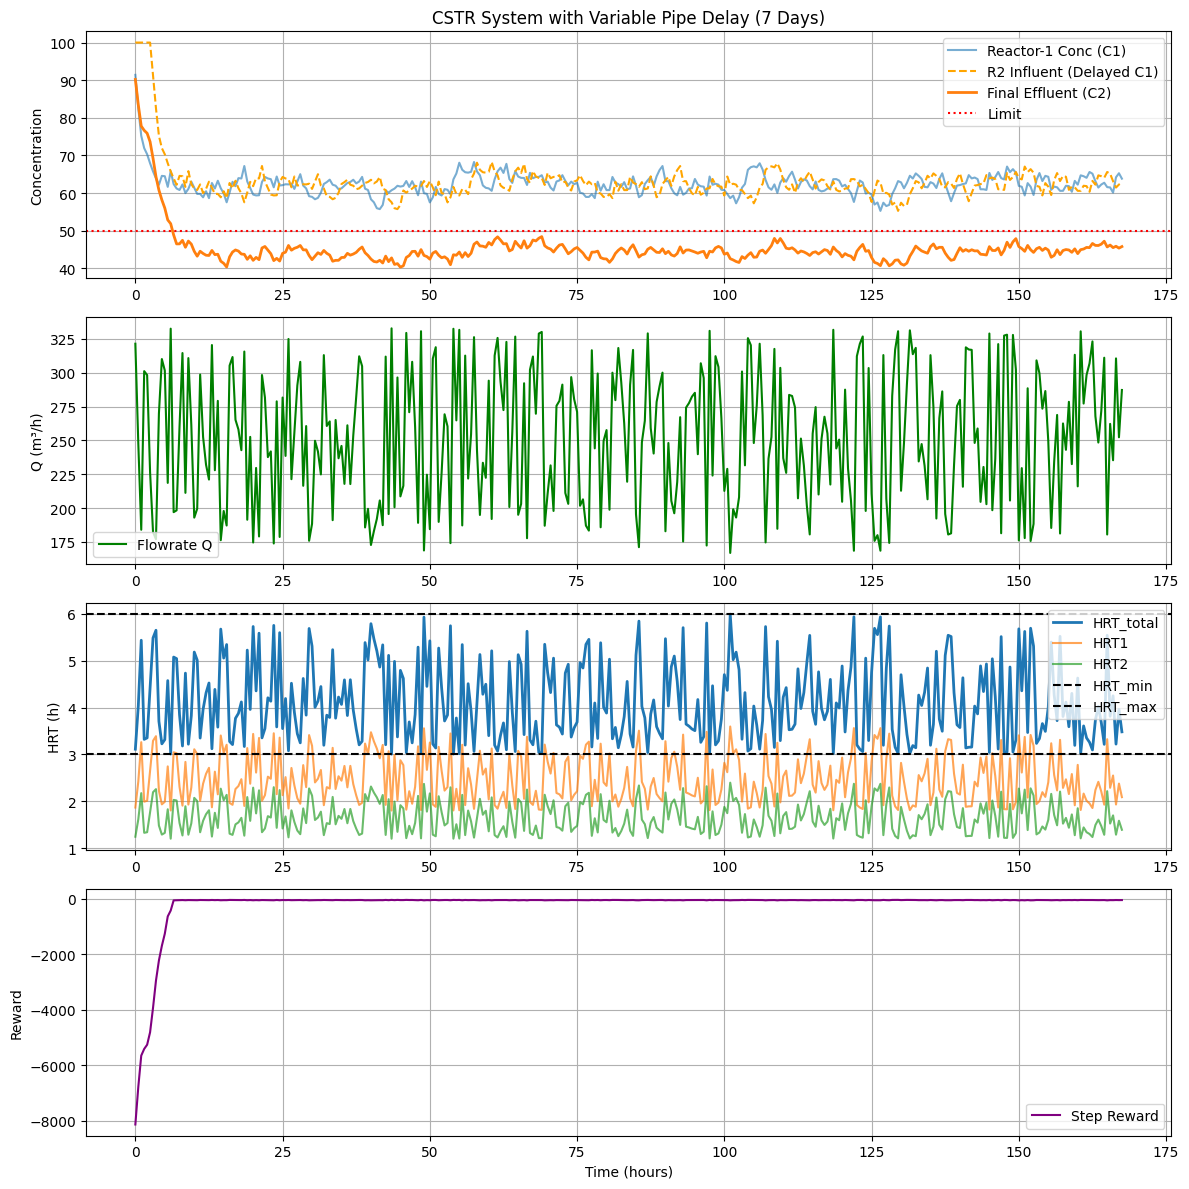

In [ ]:
dt = 0.5               # hours
days = 7               # length of simulation (168 hours)
total_steps = int(days * 24 / dt)

# 2. Environment Setup
# X = [V1, V2, C_in, half_life, HRT_min, HRT_max, C_limit, penalty, alpha, beta, dt, noise, V_pipe]
X_params = [600, 400, 100, 2.75, 3, 6, 50, 200, 1, 5, dt, 0.1, 250]
env = CSTR_Integral_Delay_Env(X_params)
obs, _ = env.reset()

# 3. History Buffers for Plotting
time_history = np.arange(total_steps) * dt
C1_history = np.zeros(total_steps)
C2_history = np.zeros(total_steps)
C1_delayed_history = np.zeros(total_steps)
Q_history = np.zeros(total_steps)
HRT_total_history = np.zeros(total_steps)
HRT1_history = np.zeros(total_steps)
HRT2_history = np.zeros(total_steps)
reward_history = np.zeros(total_steps)

# 4. Run Simulation
for t in range(total_steps):
    action = env.action_space.sample()
    obs, reward, done, truncated, info = env.step(action)

    # Store results
    C1_history[t] = info["C1"]
    C2_history[t] = info["C2"]
    C1_delayed_history[t] = info["C1_delayed"]
    Q_history[t] = info["Q"]
    reward_history[t] = reward

    # Calculate HRTs based on current Q
    HRT_total_history[t] = env.Vt / info["Q"]
    HRT1_history[t] = env.V1 / info["Q"]
    HRT2_history[t] = env.V2 / info["Q"]

# 5. Generate Plots
plt.figure(figsize=(12, 12))

# Subplot 1: Concentrations
plt.subplot(4, 1, 1)
plt.plot(time_history, C1_history, label="Reactor-1 Conc (C1)", alpha=0.6)
# The delayed influent that R2 actually "sees"
plt.plot(time_history, C1_delayed_history, label="R2 Influent (Delayed C1)", linestyle="--", color='orange')
plt.plot(time_history, C2_history, label="Final Effluent (C2)", linewidth=2)
plt.axhline(env.C_limit, color='red', linestyle=":", label="Limit")
plt.ylabel("Concentration")
plt.title(f"CSTR System with Variable Pipe Delay ({days} Days)")
plt.legend()
plt.grid(True)

# Subplot 2: Flowrate Q
plt.subplot(4, 1, 2)
plt.plot(time_history, Q_history, color='green', label="Flowrate Q")
plt.ylabel("Q (m³/h)")
plt.legend()
plt.grid(True)

# Subplot 3: HRTs
plt.subplot(4, 1, 3)
plt.plot(time_history, HRT_total_history, label="HRT_total", linewidth=2)
plt.plot(time_history, HRT1_history, label="HRT1", alpha=0.7)
plt.plot(time_history, HRT2_history, label="HRT2", alpha=0.7)
plt.axhline(env.HRT_min, color='black', linestyle="--", label="HRT_min")
plt.axhline(env.HRT_max, color='black', linestyle="--", label="HRT_max")
plt.ylabel("HRT (h)")
plt.legend()
plt.grid(True)

# Subplot 4: Reward
plt.subplot(4, 1, 4)
plt.plot(time_history, reward_history, color='purple', label="Step Reward")
plt.xlabel("Time (hours)")
plt.ylabel("Reward")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()